# PROJECT-3. Анализ воронки

Для повышения эффективности приложения Quiz Freeze команда обратилась за помощью в проверке следующих гипотез:

ГИПОТЕЗА 1. Влияет ли обучение на скорость прохождения других этапов игры?

ГИПОТЕЗА 2. Влияет ли повторное прохождение обучения положительно на оплату?

ГИПОТЕЗА 3. Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

## Цель:  исследовать поведение пользователей в обновлённом приложении

## Задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

## Формализованные задачи:
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

### ПОДГОТОВКА ДАННЫХ К АНАЛИЗУ

#### Шаг 1. Взять данные за необходимый период времени (2018 год)

- импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

- использование фильтрациии для пользователей в период 2018 года в таблице events

In [2]:
# Читаем данные таблицы events в датафрейм events_df
events_df = pd.read_csv('data/events.csv', sep=',')

# Приведение столбца с датами в надлежащий формат даты, устраняем ошибочные данные
events_df['start_time'] = pd.to_datetime(events_df['start_time'], errors='coerce')

# Применение фильтра к событию регистрации в период с 01.01.2018 по 31.12.2018
mask1 = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type'] == 'registration')

# Создание списка для отфильтрованных по условию данных
users_2018 = events_df[mask1]['user_id'].to_list()

# Оставляем в новом датафрейме events_2018 только те данные, которые соответствуют условию (users_2018)
events_2018 = events_df[events_df['user_id'].isin(users_2018)]

# Проверка работы фильтрации через минимальную и максимальную даты
print(events_2018['start_time'].min())
print(events_2018['start_time'].max())

2018-01-01 03:48:40
2019-01-01 05:50:36


- использование фильтрациии для пользователей в период 2018 года в таблице purchase

In [3]:
# Читаем данные таблицы purchase в датафрейм purchase_df
purchase_df = pd.read_csv('data/purchase.csv', sep=',')

# Добавляем новый столбец event_type
purchase_df['event_type'] = 'purchase'

# Приведение столбца с датами в надлежащий формат даты, устраняем ошибочные данные
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], errors='coerce')

# Оставляем в новом датафрейме purchase_2018 только те данные, которые соответствуют условию (users_2018)
purchase_2018 = purchase_df[purchase_df['user_id'].isin(users_2018)]
display(purchase_2018)

,id,user_id,event_datetime,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1172,16846,27865,2018-01-04 14:46:10,250,purchase
1174,16848,27911,2018-01-07 08:19:12,50,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase
...,...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100,purchase
2768,18442,47647,2019-01-02 23:26:26,150,purchase
2769,18443,47554,2019-01-03 00:36:36,50,purchase
2774,18448,47742,2019-01-04 12:51:41,50,purchase


#### Шаг 2. Разделить пользователей на следующие группы:
1) те, кто начал и завершил обучение в игре;
2) те, кто не начинал обучение в игре;
3) те, кто начал, но не завершил обучение в игре.

Также выделим общее количество уникальных зарегистрированных пользователей:

- объединение двух датафрейма events_2018 и purchase_2018 в единый total_df и подсчет уникального количества зарегистрированных пользователей

In [4]:
# Переименуем столбцы в обоих датафреймах
events_2018 = events_2018.rename(columns={"id": "event_id"})
purchase_2018 = purchase_2018.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

# Объединим и посчитаем общее уникальное количество зарегистрированных пользователей
total_df = pd.concat([events_2018, purchase_2018]).reset_index(drop=True)

cnt_total_unique_users = int(len(total_df.user_id.unique()))
print('Всего уникальных пользователей:', cnt_total_unique_users)
display(events_2018)
display(purchase_2018)
display(total_df)

Всего уникальных пользователей: 19926


,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
...,...,...,...,...,...,...
118359,147262,tutorial_start,NaN,2019-01-01 03:26:18,49554.0,47756
118360,147263,tutorial_finish,NaN,2019-01-01 03:29:25,49554.0,47756
118362,147265,level_choice,easy,2019-01-01 05:04:52,NaN,47755
118363,147266,level_choice,medium,2019-01-01 05:42:11,NaN,47756


,purchase_id,user_id,start_time,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1172,16846,27865,2018-01-04 14:46:10,250,purchase
1174,16848,27911,2018-01-07 08:19:12,50,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase
...,...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100,purchase
2768,18442,47647,2019-01-02 23:26:26,150,purchase
2769,18443,47554,2019-01-03 00:36:36,50,purchase
2774,18448,47742,2019-01-04 12:51:41,50,purchase


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,2019-01-02 03:48:19,NaN,47498,18441.0,100.0
68555,NaN,purchase,NaN,2019-01-02 23:26:26,NaN,47647,18442.0,150.0
68556,NaN,purchase,NaN,2019-01-03 00:36:36,NaN,47554,18443.0,50.0
68557,NaN,purchase,NaN,2019-01-04 12:51:41,NaN,47742,18448.0,50.0


- создание списков пользователей: 

In [5]:
# Те пользователи, которые закончили обучение
tutorial_finished_list = total_df[
    total_df["event_type"] == "tutorial_finish"][
    "user_id"
].unique()

# Те пользователи, которые начали обучение, но не закончили его
tutorial_started_list = total_df[total_df["event_type"] == "tutorial_start"][
    "user_id"
].unique()

 ### ГИПОТЕЗА 1. Влияет ли обучение на скорость прохождения других этапов игры?

 ### ЗАДАЧА 1. Определить, насколько обучение сокращает время прохождения этапов игры.

#### Шаг 1. Посчитать разницу между этапами

- создание сводной таблицы с минимальными показателями дат по всем событиям

In [6]:
pivot_df = total_df.pivot_table(values='start_time', 
                                index='user_id', 
                                columns='event_type', 
                                aggfunc='min').reset_index()
pivot_df

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40
...,...,...,...,...,...,...,...
19921,47753,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56
19922,47754,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT
19923,47755,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14
19924,47756,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2018-12-31 23:17:30,2019-01-01 03:29:25,2019-01-01 03:26:18


- создание функции, которая будет определять статус обучения для пользователя

In [7]:
def status(x, user_id):
    if x[user_id] in tutorial_finished_list:
        return 'Закончил'
    elif x[user_id] in tutorial_started_list:
        return 'Начал, но не закончил'
    else:
        return 'Не начинал'

# Создадим новый признак, который будет содержать в себе информацию о статусе пользователя
pivot_df['user_group'] = pivot_df.apply(lambda x: status(x, 'user_id'), axis=1)
pivot_df

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,user_group
0,27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,Не начинал
1,27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,Закончил
2,27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,Закончил
3,27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,Закончил
4,27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,Закончил
...,...,...,...,...,...,...,...,...
19921,47753,2018-12-31 22:36:19,2018-12-31 22:38:05,NaT,2018-12-31 18:58:55,2018-12-31 20:57:07,2018-12-31 20:54:56,Закончил
19922,47754,NaT,NaT,NaT,2018-12-31 19:14:08,NaT,NaT,Не начинал
19923,47755,2019-01-01 05:04:52,NaT,NaT,2018-12-31 21:15:14,2019-01-01 00:09:30,2019-01-01 00:08:14,Закончил
19924,47756,2019-01-01 05:42:11,2019-01-01 05:50:36,NaT,2018-12-31 23:17:30,2019-01-01 03:29:25,2019-01-01 03:26:18,Закончил


- подсчет разницы во времени между этапами registration, purchase, pack_choice, level_choice

In [8]:
# Создание столбцов c разницей во времени между каждым этапом

# Разница (delta) во времени между регистрацией (reg) и покупкой
pivot_df['delta_reg_purchase'] = (pivot_df['purchase'] - pivot_df['registration']) / pd.Timedelta('1 hour')

# Разница (delta) во времени между регистрацией (reg) и выбором пакетов вопросов
pivot_df['delta_reg_pack_choice'] = (pivot_df['pack_choice'] - pivot_df['registration']) / pd.Timedelta('1 hour')

# Разница (delta) во времени между регистрацией (reg) и выбором уровня сложности
pivot_df['delta_reg_level_choice'] = (pivot_df['level_choice'] - pivot_df['registration']) / pd.Timedelta('1 hour')

- группировка данных (разница во времени между этапами) по среднему показателю времени

In [9]:
# Среднее между регистрацией и покупкой по группе пользователей:
grouped_delta_reg_purchase = round(pivot_df.groupby('user_group', as_index=False)[['delta_reg_purchase']].mean(),2)

# Среднее между регистрацией и выбором пакета вопросов по группе пользователей:
grouped_delta_reg_pack_choice = round(pivot_df.groupby('user_group', as_index=False)[['delta_reg_pack_choice']].mean(),2)

# Среднее между регистрацией и выбором уровня сложности по группе пользователей:
grouped_delta_reg_level_choice = round(pivot_df.groupby('user_group', as_index=False)[['delta_reg_level_choice']].mean(),2)

#### Шаг 2. Построение визуализации

Создадим столбчатые диаграммы, на которых изобразим разницу во времени между этапами

- Диаграмма №1: средняя разница во времени между регистрацией и покупкой

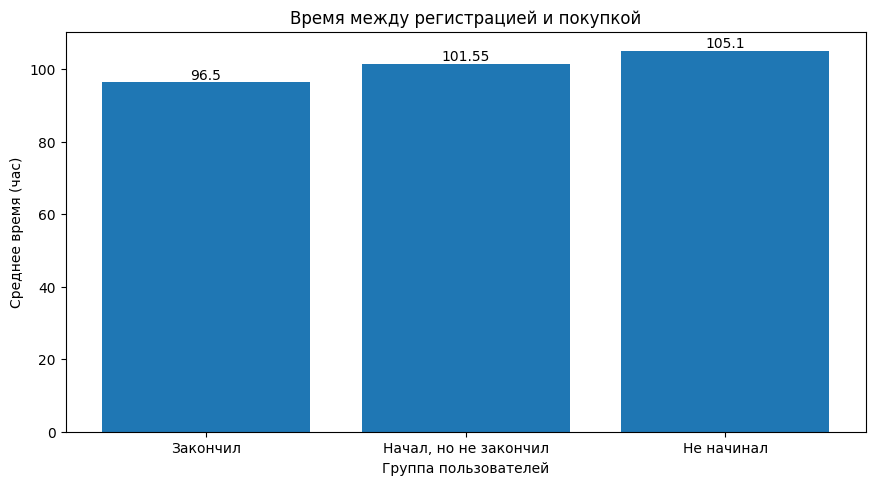

In [10]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0,0,1,1])
bar_group_1 = axes.bar(
    x =  grouped_delta_reg_purchase['user_group'],
    height = grouped_delta_reg_purchase['delta_reg_purchase'])
axes.set_title('Время между регистрацией и покупкой')
axes.set_ylabel('Среднее время (час)')
axes.set_xlabel('Группа пользователей')
axes.bar_label(bar_group_1);

- Диаграмма №2: средняя разница во времени между регистрацией и выбором пакетов вопросов

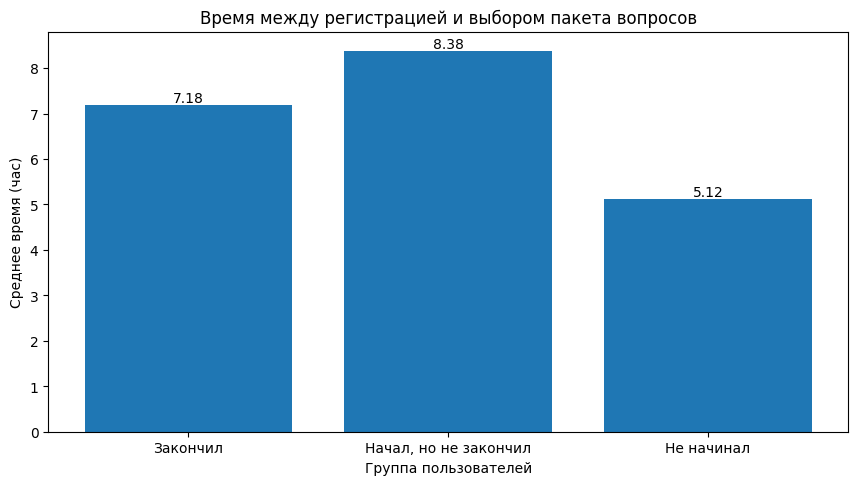

In [11]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0,0,1,1])
bar_group_2 = axes.bar(
    x =  grouped_delta_reg_pack_choice['user_group'],
    height = grouped_delta_reg_pack_choice['delta_reg_pack_choice'])
axes.set_title('Время между регистрацией и выбором пакета вопросов')
axes.set_ylabel('Среднее время (час)')
axes.set_xlabel('Группа пользователей')
axes.bar_label(bar_group_2);

- Диаграмма №3: средняя разница во времени между регистрацией и выбором уровня сложности

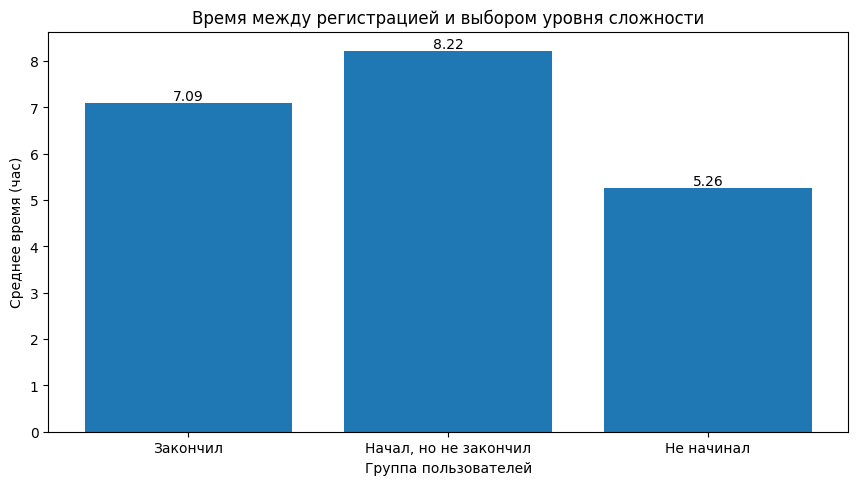

In [12]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0,0,1,1])
bar_group_3 = axes.bar(
    x =  grouped_delta_reg_level_choice['user_group'],
    height = grouped_delta_reg_level_choice['delta_reg_level_choice'])
axes.set_title('Время между регистрацией и выбором уровня сложности')
axes.set_ylabel('Среднее время (час)')
axes.set_xlabel('Группа пользователей')
axes.bar_label(bar_group_3);

### ВЫВОДЫ:  

Диаграмма №1 показывает, что пользователи, закончившие обучение, тратят меньше всего времени между регистрацией и покупкой.

Диаграмма №2 показывает, что пользователи, не закончившие обучение до конца, имеют самую большую разницу во времени между регистрацией и выбором пакета вопросов, в то время как пользователи, не начавшие обучение, тратят меньше всего времени.

Диаграмма №3 показывает, что снова пользователи, не закончившие обучение, тратят больше всего времени между регистрацией и выбором уровня сложности, тогда как те, кто не начинал обучение, имеют самую низкую разницу во времени.



### ОТВЕТ НА ГИПОТЕЗУ 1 - Влияет ли обучение на скорость прохождения других этапов игры?

Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение? Очевидно, разница есть. В особенности между группами, которые проходят обучение до конца, и теми, что нет. Обучение способствует разъяснению многих моментов, которые предстоит встретить в игре. Некоторые закрывают обучение, а впоследствии сталкиваются с трудностями, которые стопорят процесс. Есть также некоторые, кто игнорируют обучение и быстро двигаются дальше (возможно, они уже предварительно знакомы с логикой игры).
Следует также отметить тот факт, что пройденное обучение способствует более быстрому переходу к покупке (см. Диаграмма №1).

__________________________________________________________________________________________________________________________________________________________________________________________

### ГИПОТЕЗА 2.  Влияет ли повторное прохождение обучения положительно на оплату?  
### ЗАДАЧА 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

#### Шаг 1. Сгруппировать данные по группам пользователей и количеству оформленных покупок

- создание сводной таблицы с общим количеством событий у каждого пользователя

In [13]:
pivot_grouped = total_df.pivot_table(values = 'start_time',
                                    index = 'user_id',
                                    columns = 'event_type',
                                    aggfunc = 'count',
                                    fill_value = 0).reset_index()
pivot_grouped.columns = ['user_id', 'level_choice', 'pack_choice', 'purchase', 'registration', 'tutorial_finish', 'tutorial_start']
pivot_grouped

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,0,0,0,1,0,0
1,27833,0,0,0,1,1,1
2,27834,0,0,0,1,1,1
3,27835,1,1,0,1,1,1
4,27836,0,0,0,1,1,2
...,...,...,...,...,...,...,...
19921,47753,1,1,0,1,1,1
19922,47754,0,0,0,1,0,0
19923,47755,1,0,0,1,1,1
19924,47756,1,1,0,1,1,1


- группировка пользователей, которые начали прохождение обучения, по типам события registration и purchase

In [14]:
grouped_tut_st_purchase = pivot_grouped.groupby(['tutorial_start'])[['registration', 'purchase']].sum().reset_index()
grouped_tut_st_purchase

,tutorial_start,registration,purchase
0,0,8068,22
1,1,9103,1207
2,2,1589,218
3,3,427,51
4,4,221,30
5,5,109,16
6,6,116,14
7,7,94,12
8,8,86,13
9,9,113,17


- подсчет процента количества пользователей, совершивших покупку

In [15]:
grouped_tut_st_purchase['percent'] = round(grouped_tut_st_purchase['purchase'] / grouped_tut_st_purchase['registration'] * 100, 1)
display(grouped_tut_st_purchase)

,tutorial_start,registration,purchase,percent
0,0,8068,22,0.3
1,1,9103,1207,13.3
2,2,1589,218,13.7
3,3,427,51,11.9
4,4,221,30,13.6
5,5,109,16,14.7
6,6,116,14,12.1
7,7,94,12,12.8
8,8,86,13,15.1
9,9,113,17,15.0


#### Шаг 2. Создание визуализации

- построение столбчатой диаграммы, которая покажет соотношение факта совершения покупки к количеству пройденных обучений

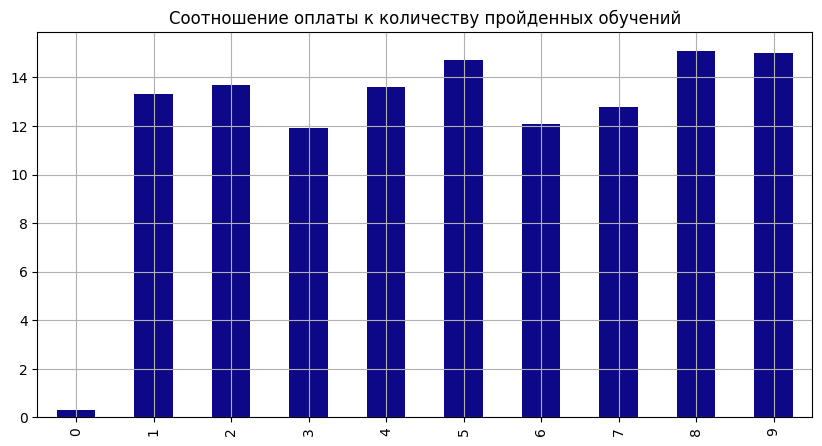

In [16]:
grouped_tut_st_purchase['percent'].plot(
    kind='bar',
    grid=True,
    figsize=(10, 5),
    colormap='plasma',
    title = 'Соотношение оплаты к количеству пройденных обучений'
);

### ВЫВОДЫ:  
Как показывает диаграмма "Соотношение оплаты к количеству пройденных обучений", самый высокий показатель имеют пользователи, которые прошли обучение 8, 9 и 5 раз, соответственно. 
Исходя из этого, можно сделать вывод, что большую часть дохода приносит группа пользователей, которые проходят обучение более 7 раз.


### ОТВЕТ НА ГИПОТЕЗУ 2 - Влияет ли повторное прохождение обучения положительно на оплату?
Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь? Определенно, да. Повторное прохождение обучения положительно влияет на совершение покупки. 

__________________________________________________________________________________________________________________________________________________________________________________________

### ГИПОТЕЗА 3. Если пользователь сначала выбирает сложность, будет ли он потом проходить обучение?
### ЗАДАЧА 3. Определить, насколько прозрачен* процесс взаимодействия с игрой.


*под прозрачностью понимается, насколько легок и доступен для понимания пользователям геймплей приложения, логика игры

Для того, чтобы рассчитать прозрачность игры, выделим два пути игроков: 
1) начало обучение -> выбор уровня сложности;
2) выбор уровня сложности -> начало обучения.

И посчитаем количество пользователей, выбравших 1-ый или 2-ой путь. Так мы поймем, часто ли возникают трудности при использовании приложения и насколько оно прозрачно.

#### Шаг 1. Выделить группы пользователей, выбравших 1-ый либо 2-ой путь

- создание датафрейма, включающего информацию по пользователям, начавшим обучение, и тем, кто выбрал уровень сложности

In [17]:
# Выделим тех пользователей, кто начал обучение (tutorial_start)
users_tutorial_start = total_df[total_df['event_type'] == 'tutorial_start']

# Выделим тех пользователей, кто выбрал уровень сложности (level_choice)
users_level_choice = total_df[total_df['event_type'] == 'level_choice']

# Переименуем признак start_time на level_choice_time
users_level_choice = users_level_choice.rename(columns={'start_time': 'level_choice_time'}) 
                                               
# Объединяем таблицы 
delta_tut_start_level_choice = users_tutorial_start[['user_id', 'start_time']].merge(
    users_level_choice[['user_id', 'level_choice_time']],
    on='user_id',
    how='inner'
)

# Создадим новый признак разницы во времени между этапами начала обучения и выбора уровня сложности
delta_tut_start_level_choice['delta_time'] = delta_tut_start_level_choice['level_choice_time'] - delta_tut_start_level_choice['start_time']
delta_tut_start_level_choice


,user_id,start_time,level_choice_time,delta_time
0,27835,2018-01-01 15:00:51,2018-01-01 20:37:22,0 days 05:36:31
1,27839,2018-01-01 19:11:36,2018-01-01 22:37:50,0 days 03:26:14
2,27840,2018-01-02 02:07:07,2018-01-02 05:18:42,0 days 03:11:35
3,27845,2018-01-02 03:03:44,2018-01-02 06:19:18,0 days 03:15:34
4,27842,2018-01-02 04:55:11,2018-01-02 08:46:03,0 days 03:50:52
...,...,...,...,...
12681,47732,2018-12-31 07:14:38,2018-12-31 09:59:00,0 days 02:44:22
12682,47747,2018-12-31 10:21:11,2018-12-31 12:24:40,0 days 02:03:29
12683,47753,2018-12-31 20:54:56,2018-12-31 22:36:19,0 days 01:41:23
12684,47755,2019-01-01 00:08:14,2019-01-01 05:04:52,0 days 04:56:38


- расчет количества пользователей, которые выбрали путь "начало обучения -> выбор уровня сложности"

In [18]:
users_tut_then_level_choice = delta_tut_start_level_choice.query('delta_time > "1 second"')['user_id'].nunique() 
print('Количество пользователей, выбравших путь "начало обучения -> выбор уровня сложности":', users_tut_then_level_choice)

Количество пользователей, выбравших путь "начало обучения -> выбор уровня сложности": 8244


- расчет количества пользователей, которые выбрали путь "выбор уровня сложности -> начало обучения"

In [19]:
users_level_choice_then_tut = delta_tut_start_level_choice.query('delta_time < "0 second"')['user_id'].nunique() 
print('Количество пользователей, выбравших путь "выбор уровня сложности -> начало обучения":', users_level_choice_then_tut)

Количество пользователей, выбравших путь "выбор уровня сложности -> начало обучения": 1386


- расчет доли пользователей, выбравших путь "выбор уровня сложности -> начало обучения"

In [20]:
delta_percent = users_level_choice_then_tut / users_tut_then_level_choice
print('Доля пользователей, выбравших путь "выбор уровня сложности -> начало обучения": {:.2%}'.format(delta_percent))

Доля пользователей, выбравших путь "выбор уровня сложности -> начало обучения": 16.81%


### ВЫВОДЫ:  
Таким образом, путь "начало обучения -> выбор уровня сложности" выбрало 8244 человек, а путь "выбор уровня сложности -> начало обучения" - 1386, что составляет 17%.


### ОТВЕТ НА ГИПОТЕЗУ 3 - Если пользователь сначала выбирает сложность, будет ли он потом проходить обучение?
Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок? - Как мы видим, большая часть пользователей сначала проходят обучение, а затем выбирают уровень сложности. Однако, есть и такая группа пользователей (17%), которые после выбора уровня сложности возвращаются к прохождению обучения, что намекает о возможно возникающих трудностях при пользовании игры.

__________________________________________________________________________________________________________________________________________________________________________________________________________________________

## ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:

Исходя из вышеисложенных выводов, можно выделить следующее:
- прохождение обучения влияет на скорость прохождения других этапов (самые низкие показатели у группы пользователей "начал, но не закончил");
- повторное прохождение обучения положительно влияет на оплату (самый высокие показатель - > 7 раз);
- у 17% пользователей возникают трудности при прохождении игры.

Таким образом, следует сконцентрировать свои силы на привлечение пользователей к прохождению обучения. Так, можно не только помочь пользователям разобраться со всеми нюансами приложения, но также и задержать его в приложении как можно дольше.